# Minimal demo: Lorenz Score SDE
This short notebook walks through the **end‑to‑end pipeline**:
1. Generate a training set of noisy Lorenz‑63 trajectories
2. Train a tiny score network (a couple of epochs, just for demo)
3. Sample new trajectories with a Predictor–Corrector solver
4. Compare sampled and ground‑truth marginals

Run each cell in sequence inside your project’s virtual‑env.

## 0  Setup
Make sure you’ve run:
```bash
pip install -r requirements.txt
```
and that the project root is on `sys.path`, so Python can import the `data` and `scripts` modules.

In [4]:
import os, sys, pathlib, itertools
# Walk up until we find a folder that contains the 'data' directory
cwd = pathlib.Path().resolve()
for parent in itertools.chain([cwd], cwd.parents):
    if (parent / 'data').is_dir():
        os.chdir(parent)
        break
print('Project root →', pathlib.Path().resolve())
# Ensure repo root is on sys.path so `import data` works even if not installed
if str(pathlib.Path().resolve()) not in sys.path:
    sys.path.insert(0, str(pathlib.Path().resolve()))

Project root → /home/sbdeery/lorenz63-sgm


## 1  Generate data

In [5]:
# This writes two files: data/lorenz_train_norm.npy and data/lorenz_stats.json
!python data/make_data.py --dist lorenz --outdir data

Saved (500000, 3) to data


### Quick look at one trajectory

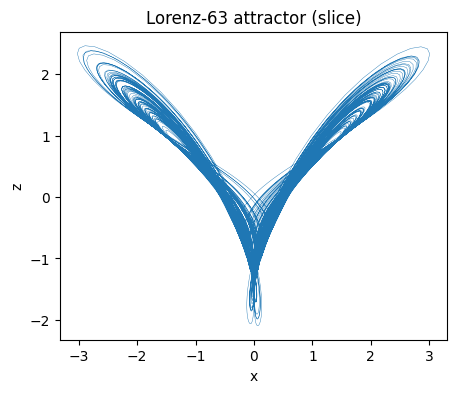

In [7]:
xs = np.load('data/lorenz_train_norm.npy')[:10000]  # first trajectory sample
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(xs[:,0], xs[:,2], linewidth=0.3)
ax.set_xlabel('x'); ax.set_ylabel('z'); ax.set_title('Lorenz‑63 attractor (slice)');

## 2  Train a *tiny* score model
Here we train for just **2 epochs** so it finishes in a minute or two on CPU. For research, crank this up (see README for full command).

In [10]:
!python -m scripts.train \
        --data data/lorenz_train_norm.npy \
        --out demo_outputs \
        --epochs 2 \
        --batch 128

Epoch 2: 100%|█████████████████████████████| 3515/3515 [00:26<00:00, 132.94it/s]


## 3  Sample with a Predictor–Corrector solver

In [12]:
!python -m scripts.sample \
        --ckpt demo_outputs/ckpts/e02.pt \
        --n 10000 \
        --sample_type pc \
        --out demo_outputs/pc_samples.npz

Saved 10000 samples to demo_outputs/pc_samples.npz


## 4  Evaluate marginals

In [13]:
!python -m scripts.eval_marginals \
        --data data/lorenz_train_norm.npy \
        --samples demo_outputs/pc_samples.npz \
        --stats data/lorenz_stats.json \
        --outdir demo_outputs/marginal_eval \
        --bins 150

x: KS=0.0752  W1=1.0840  KDE-MSE=4.00e-05
y: KS=0.0525  W1=0.7924  KDE-MSE=2.64e-05
z: KS=0.0527  W1=1.2537  KDE-MSE=6.98e-06


### Visual sanity check

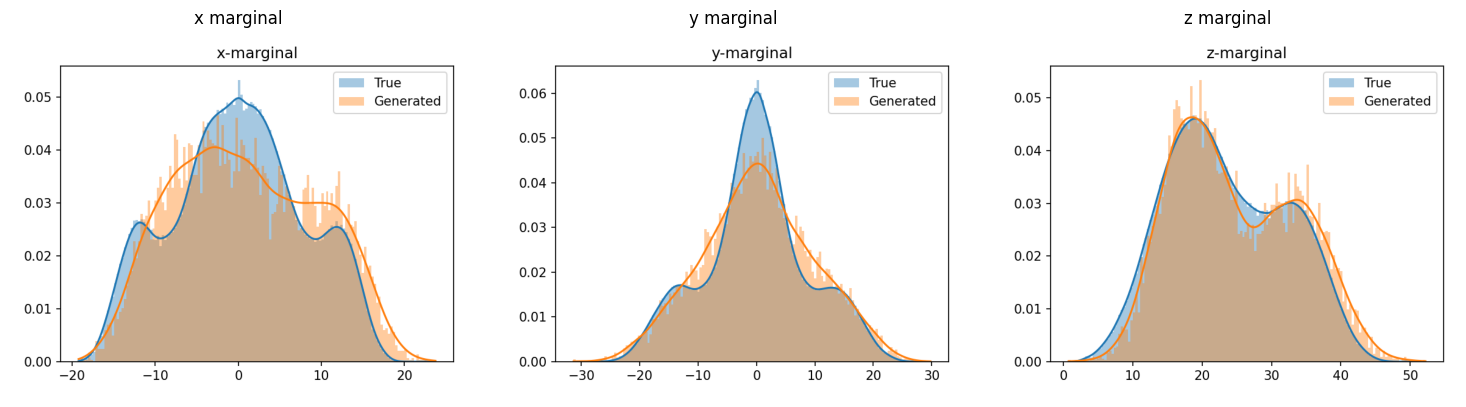

In [18]:
# ── Display saved marginal plots ─────────────────────────────────────────
import matplotlib.pyplot as plt, matplotlib.image as mpimg, pathlib

eval_dir = pathlib.Path("demo_outputs/marginal_eval")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, axis in zip(axes, ["x", "y", "z"]):
    img_path = eval_dir / f"{axis}.png"
    if img_path.exists():
        ax.imshow(mpimg.imread(img_path))
        ax.set_title(f"{axis} marginal")
    else:
        ax.text(0.5, 0.5, "missing", ha="center", va="center")
    ax.axis("off")

plt.tight_layout()
